# Create dataset for check-mark

### Target: Create a generator for symbol marked documents
Examples:

|Fig.1: Marked document sample|
|:--:|
|<img src="fig/sample.png" width="600">|

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import glob
import random
from tqdm import tqdm

# SETUP COLOR
COLOR_ARR = {
    "text": [255,255,0],
    "box": [0,255,0],
    "check":[255,0,0],
    "maru":[0,0,255],
    "○":[0,0,255],
}

# SETUP MAPPING
CMAP = {
    "check": ["box"],
    "maru": ["roi"],
    "○": ["roi"],
}
# SETUP CONFIG
CONFIG = {
    "mark": "check",
    "fillrate": 0.5,
    "scalerate": [0.9, 1.8],
}
"""
CONFIG.update({
    'mark': 'maru',
    "scalerate": [1., 2.],
})
"""
FILLRATE = CONFIG.get('fillrate')
SCALERATE = CONFIG.get('scalerate')

# SETUP SAMPLES
N_SAMPLES = 200

# make dset
FINAL = True

## Demo

In [2]:
template_path = "/mnt/sda1/data/template/mark/f13-01.gif"
xml_path = "/mnt/sda1/data/template/mark/f13-01.xml"
mark = CONFIG.get('mark')
db_path = f"/mnt/sda1/data/mark_db/{mark}"
templates_path = f"/mnt/sda1/data/template/{mark}"
store_path = f"/mnt/sda1/data/generated{mark}_dataset_{N_SAMPLES}_{SCALERATE[0]}_{SCALERATE[1]}"
os.makedirs(store_path, exist_ok=True)

In [3]:
def transform(symbol_img, box_shape):
    rt = box_shape[0] / min(symbol_img.shape[:2]) * random.uniform(SCALERATE[0], SCALERATE[1])
    # random ratio
    if CONFIG.get('mark') == "maru":
        rtx = rt * symbol_img.shape[0] / symbol_img.shape[1] * box_shape[1] / box_shape[0] * random.uniform(0.9, 1.1)
    else:
        rtx = rt * random.uniform(0.5, 1.5)
    symbol_img_resized = cv2.resize(symbol_img, None, fx=rtx, fy=rt) 
    
    return symbol_img_resized

"""
img = cv2.imread("/mnt/sda1/data/mark_db/check/1C/1/94.png")
out = transform(img, (60, 60))
plt.imshow(out)

import albumentations.augmentations.transforms as transforms

aug_engine = transforms.Rotate(limit=20)
img = cv2.imread("/mnt/sda1/data/mark_db/check/1C/1/94.png")
out = aug_engine(image=img)
print(out.get('image').shape)
plt.imshow(out.get('image'))
"""

'\nimg = cv2.imread("/mnt/sda1/data/mark_db/check/1C/1/94.png")\nout = transform(img, (60, 60))\nplt.imshow(out)\n\nimport albumentations.augmentations.transforms as transforms\n\naug_engine = transforms.Rotate(limit=20)\nimg = cv2.imread("/mnt/sda1/data/mark_db/check/1C/1/94.png")\nout = aug_engine(image=img)\nprint(out.get(\'image\').shape)\nplt.imshow(out.get(\'image\'))\n'

In [4]:
def load_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    classes = []
    for i, obj in enumerate(root.iter('object')):
        xmlname = obj.find('name')
        xmlbox = obj.find('bndbox')
        left = int(xmlbox.find('xmin').text)
        right = int(xmlbox.find('xmax').text)
        top = int(xmlbox.find('ymin').text)
        bottom = int(xmlbox.find('ymax').text)
        boxes.append((top, left, bottom, right))
        
        if (xmlname.text == "maru"):
            xmlname.text = '○'
        
        classes.append(xmlname.text)
        
    return boxes, classes

def draw_boxes(image, boxes, classes, mode="fill"):   
    boxed_img = Image.fromarray(img.astype(np.uint8))
    drawed_img = ImageDraw.Draw(boxed_img, mode="RGBA")
    
    
    for i, box in enumerate(boxes):
        top, left, bottom, right = box
        if COLOR_ARR.get(classes[i]) is None:
            print(f"There is no {classes[i]} in color definition")
            continue
        color_i = tuple(COLOR_ARR[classes[i]] + [64])
        #font = ImageFont.truetype('fonts/arial.ttf', 20)
        #drawed_img = ImageDraw.Draw(boxed_img)
        #drawed_img.text((left, top-20),str(round(scores[i], 2)),COLOR_ARR[color_i],font=font)
        if mode == "fill":
            drawed_img.rectangle(((left, top), (right, bottom)), fill=color_i) # red-check, blue-circle
        else:
            drawed_img.rectangle(((left, top), (right, bottom)), outline=color_i, width=2) # red-check, blue-circle
    
    return boxed_img
    
def is_image_path(img_path, extension=["jpg","jpeg","png"]):
    return os.path.basename(img_path).split(".")[-1].lower() in extension
    
def load_db(db_path, extension=["jpg","jpeg","png"]):
    list_symbol = glob.glob(db_path + "/**/*", recursive=True)
    list_symbol = [item for item in list_symbol if is_image_path(item, extension)]
    
    return list_symbol

def select_boxes(boxes, classes, mark="check", fill_rate=FILLRATE):
    TOTAL_BOXES = [box for (box, c) in zip(boxes, classes) if c in CMAP[mark]]
    TOTAL_CLASSES = [c for (box, c) in zip(boxes, classes) if c in CMAP[mark]]
    
    
    # select filled boxes
    FILL_BOXES = [box for box in TOTAL_BOXES if np.random.rand() < fill_rate]
    
    # select randomly NSYMBOL from database
    #NSYMBOL = len(FILL_BOXES)
    #idx = np.random.randint(0,TOTAL_SYMBOL,size=(NSYMBOL,))
    
    # 
    
    return TOTAL_BOXES, TOTAL_CLASSES, FILL_BOXES

#def export_xml(mark="check"):
    

def insert_symbol(image, FILL_BOXES, list_symbol, mark="check"):
    TOTAL_SYMBOL = len(list_symbol)
    NSYMBOL = len(FILL_BOXES)
    idx = np.random.randint(0,TOTAL_SYMBOL,size=(NSYMBOL,))
    
    insert_boxes = []
    insert_classes = []
    
    for i in range(NSYMBOL):
        try:
            symbol_path = list_symbol[idx[i]]
            # load symbol
            symbol_img = cv2.imread(symbol_path)
            # load inserted boxes
            box = FILL_BOXES[i]
            top, left, bottom, right = box
            box_shape = bottom-top, right-left

            #print(box)
            # rescale symbol
            """
            rt = box_shape[0] / min(symbol_img.shape[:2]) * random.uniform(SCALERATE[0], SCALERATE[1])
            symbol_img_resized = cv2.resize(symbol_img, None, fx=rt, fy=rt)
            """
            symbol_img_resized = transform(symbol_img, box_shape)
            h, w = symbol_img_resized.shape[:2]

            # symbol position
            if mark == "check":
                y_noise, x_noise = np.random.randn() * box_shape[0]/4, np.random.randn() * box_shape[1]/4
                x_symbol = int(left + x_noise) # int(0.5*(left+right) - 0.5*w + x_noise)
                y_symbol = int(0.1*top + 0.9*bottom - h + y_noise) #int(0.5*(top+bottom) - 0.5*h + y_noise)
            elif mark == "maru":
                y_noise, x_noise = np.random.randn() * box_shape[0]/10, np.random.randn() * box_shape[1]/3
                x_symbol = int(0.5*left + 0.5*right - 0.5*w + x_noise) # int(0.5*(left+right) - 0.5*w + x_noise)
                y_symbol = int(0.5*top + 0.5*bottom - 0.5*h + y_noise) #int(0.5*(top+bottom) - 0.5*h + y_noise)

            # insert to image
            insert_size = min(y_symbol + h, image.shape[0]) - y_symbol, min(x_symbol + w, image.shape[1]) - x_symbol
            insert_symbol = image[y_symbol:y_symbol + insert_size[0], x_symbol: x_symbol + insert_size[1]]
            insert_symbol = np.minimum(insert_symbol, symbol_img_resized[:insert_size[0], :insert_size[1]])


            image[y_symbol:y_symbol + insert_size[0], x_symbol: x_symbol + insert_size[1]] = insert_symbol

            # insert box
            insert_box = [y_symbol, x_symbol, y_symbol + insert_size[0], x_symbol + insert_size[1]]
            insert_boxes.append(insert_box)
            insert_classes.append(mark)
        except:
            continue
        
    return image, insert_boxes, insert_classes



In [5]:
def export_xml(image_path, image, boxes, classes, out_path=""):
    root = ET.Element('annotation')
    folder = ET.SubElement(root, 'folder')
    folder.text = "10 templates check"
    filename = ET.SubElement(root, 'filename')
    filename.text = os.path.basename(image_path)
    path = ET.SubElement(root, 'path')
    path.text = image_path
    
    source = ET.SubElement(root, 'source')
    database = ET.SubElement(source, 'database')
    database.text = "Unknown"
    
    size = ET.SubElement(root, 'size')
    width = ET.SubElement(size, 'width'); width.text = "%d" %image.shape[1]
    height = ET.SubElement(size, 'height'); height.text = "%d" %image.shape[0]
    depth = ET.SubElement(size, 'depth'); depth.text = "%d" %image.shape[2]
    
    segmented = ET.SubElement(root, 'segmented'); segmented.text = "0"
    
    for box, mark in zip(boxes, classes):
        obj = ET.SubElement(root, 'object')
        name = ET.SubElement(obj, 'name'); name.text = mark
        pose = ET.SubElement(obj, 'pose'); pose.text = "Unspecified"
        truncated = ET.SubElement(obj, 'truncated'); truncated.text = "0"
        difficult = ET.SubElement(obj, 'difficult'); difficult.text = "0"
        bndbox = ET.SubElement(obj, 'bndbox')
        top, left, bottom, right = box
        xmin = ET.SubElement(bndbox, 'xmin'); xmin.text = "%d" %(min(left, right))
        ymin = ET.SubElement(bndbox, 'ymin'); ymin.text = "%d" %(min(top, bottom))
        xmax = ET.SubElement(bndbox, 'xmax'); xmax.text = "%d" %(max(left, right))
        ymax = ET.SubElement(bndbox, 'ymax'); ymax.text = "%d" %(max(top, bottom))
    
    # out = ET.tostring(root)
    xml_name = os.path.join(out_path, ".".join(filename.text.split(".")[:-1]) + ".xml")
    tree = ET.ElementTree(root)
    tree.write(xml_name)


In [6]:
import imageio
def imread(img_path):
    extension = img_path.split(".")[-1].lower()
    if extension in ['jpg','jpeg','png']:
        return cv2.imread(img_path)
    elif extension in ['gif']:
        img = imageio.mimread(template_path)
        return np.stack((img[0], img[0], img[0]), axis=-1).astype(np.uint8)
    else:
        print("Not supported image extension")
        return
        

[]


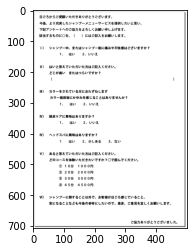

In [7]:
img = imread(template_path)
boxes, classes = load_annotation(xml_path)
list_symbol = load_db(db_path)
TOTAL_BOXES, TOTAL_CLASSES, FILL_BOXES = select_boxes(boxes, classes, mark=mark)
print(TOTAL_BOXES)
img, insert_boxes, insert_classes = insert_symbol(img, FILL_BOXES, list_symbol, mark=mark)

export_xml(template_path, img, insert_boxes, insert_classes)

plt.imshow(img)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#boxed_img = draw_boxes(image, TOTAL_BOXES, TOTAL_CLASSES)
boxed_img = image
gen_boxes, gen_classes = load_annotation(os.path.basename(xml_path))
boxed_img = draw_boxes(boxed_img, gen_boxes, gen_classes)
#boxed_img = draw_boxes(boxed_img, FILL_BOXES, ["check" for i in range(len(FILL_BOXES))], mode="outline")
plt.imshow(boxed_img)
boxed_img.save("demo.png")

# MAKE DATASET

In [8]:
if FINAL:
    template_list = glob.glob(templates_path + "/*")
    template_list = [item for item in template_list if ".xml" not in item]
    list_symbol = load_db(db_path)

    with tqdm(total=N_SAMPLES) as pbar:
        for i in range(N_SAMPLES):
            random_idx = random.randrange(0, len(template_list))
            template_path = template_list[random_idx]
            xml_path = ".".join(template_path.split(".")[:-1]) + ".xml"

            # load image
            img = imread(template_path)
            # load annotation
            boxes, classes = load_annotation(xml_path)
            # select filling boxes
            TOTAL_BOXES, TOTAL_CLASSES, FILL_BOXES = select_boxes(boxes, classes, mark=mark)
            # insert symbol
            img, insert_boxes, insert_classes = insert_symbol(img, FILL_BOXES, list_symbol, mark=mark)

            # export output
            image_store_path = os.path.join(store_path, f"{mark}_{i}.png")
            cv2.imwrite(image_store_path, img)

            export_xml(image_store_path, img, insert_boxes, insert_classes, out_path=store_path)

            pbar.update(1)
    

100%|██████████| 200/200 [00:07<00:00, 26.08it/s]
